In [127]:
pip install spacy_transformers --quiet

Note: you may need to restart the kernel to use updated packages.


In [126]:
!pip install -U spacy --quiet

In [199]:
pip --version

pip 23.2.1 from /Users/bellagracefinck/anaconda3/lib/python3.11/site-packages/pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer

In [2]:
designers = pd.read_csv('designers.csv').drop(columns = 'Unnamed: 0')
designers.head(2)

,designer,collections,first_season,consistency,prevalence,class
0,comme-des-garcons,65,1991.0,0.984848,0.969464,5
1,versace,61,1991.0,0.924242,0.907849,4


In [3]:
collections = pd.read_csv('collections.csv').drop(columns = 'Unnamed: 0')
collections.head(2)

,season,year,seasonyear,designer,text,id,preprocessed_sentences,consistency,prevalence,class
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,2
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0


In [70]:
train = pd.read_csv('word_labels.csv')
train['word'] = [word.lower() for word in train['word']]
train.head()

,word,label
0,alizarin,COLOR
1,amaranth,COLOR
2,amber,COLOR
3,amethyst,COLOR
4,apricot,COLOR


In [71]:
from nltk.stem import WordNetLemmatizer
import string
from gensim.parsing import preprocess_string 

lemmatizer = WordNetLemmatizer()

for word in train['word']:
    lem = lemmatizer.lemmatize(word)
    pre = preprocess_string(word)
    if lem != word:
        temp = pd.DataFrame([{'word': lem, 'label': list(train[train['word']==word]['label'])[0]}])
        train = pd.concat([train, temp], ignore_index=True)
    if pre != word:
        temp = pd.DataFrame([{'word': pre[0], 'label': list(train[train['word']==word]['label'])[0]}])
        train = pd.concat([train, temp], ignore_index=True)
        
train = train.drop_duplicates('word')

In [73]:
grouped_labels = train.groupby('label')['word'].apply(list).to_dict()

## Named Entity Recognition
For this project, I decided to create my own rudimentary NER model that is tailored (no pun intended) specifically to identify attributes of fashion collections. This model is not extensive by any means, but it provides a good starting place for my research in tracking trends.

I have two versions of this - one spacy model that is a work in progress (it will occasionally throw errors randomly) and a simpler version that manually annotates the data based on the NER labels. 

In [74]:
import spacy
from spacy.language import Language
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])


# Create patterns for each label
label_patterns = {label: list(nlp.pipe(words)) for label, words in grouped_labels.items()}

# Initialize PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)
for label, patterns in label_patterns.items():
    matcher.add(label, patterns)

# Define the custom component for fashion term labeling
@Language.component("fashion_component")
def fashion_component_function(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label to the span
    spans = [Span(doc, start, end, label=label) for label, start, end in matches]
    # Overwrite the doc.ents with the matched spans
    doc.ents = spans
    return doc

# Add the fashion component to the SpaCy pipeline after the "ner" component
nlp.add_pipe("fashion_component", after="ner")

# Process the text and print the text and label for the doc.ents
review = collections['preprocessed_sentences'][2]
raw = collections['text'][2]
doc = nlp(review)
print(raw, '\n', [(ent.text, ent.label_) for ent in doc.ents])

Alaïa worked with pinstripes and other power materials this season. His timing was spot-on; the recession was starting to lift. While some of his sexy suiting would certainly work in a boardroom setting, the bedroom seemed the final destination for some of his lacy evening looks.</p></div> 
 [('pinstrip', 'FEATURE'), ('suit', 'GARMENT_TYPE'), ('laci', 'MATERIAL'), ('even', 'FEATURE')]


In [75]:
# Manual data annotation
import time
start = time.time()
TRAIN_DATA = []
for review in collections['preprocessed_sentences']:
    #print('\n', review)
    tokens = word_tokenize(review)
    labels = {'entities':[]}
    idx = 0
    for token in tokens:
        idx += len(token) + 1
        if token in train['word'].values:
            start_idx = idx - len(token) - 1
            end_idx = idx - 1
            label = list(train[train['word']==token]['label'])[0]
            labels['entities'].append((token, start_idx, end_idx, label))
    TRAIN_DATA.append((review, labels))

end = time.time() 
print(end-start)
len(TRAIN_DATA)

84.46047806739807


14261

In [76]:
TRAIN_DATA[0]

('enfilad stretchi knit jewel tone effect showmanship real new spring combo tailor stretch fabric refer todai athleisur touch includ fit stori april issu photograph look like beach readi look fact wear bodi suit look like bath suit meant water splashi style nonetheless',
 {'entities': [('stretchi', 8, 16, 'FEATURE'),
   ('knit', 17, 21, 'FEATURE'),
   ('tailor', 74, 80, 'FEATURE'),
   ('fit', 131, 134, 'FEATURE'),
   ('suit', 205, 209, 'GARMENT_TYPE'),
   ('suit', 225, 229, 'GARMENT_TYPE')]})

In [77]:
# create columns of fashion words and word types in collections df
descriptors = []
types = []
for i in range(len(collections['id'])):
    words = []
    word_types = []
    for x in range(len(TRAIN_DATA[i][1]['entities'])):
        if TRAIN_DATA[i][1]['entities'][x][3] != 'GARMENT_TYPE':
            words.append(TRAIN_DATA[i][1]['entities'][x][0])
            word_types.append(TRAIN_DATA[i][1]['entities'][x][3])
    descriptors.append(words)
    types.append(word_types)
    
collections['descriptors'] = descriptors
collections['labels'] = types

In [78]:
collections.head()

,season,year,seasonyear,designer,text,id,preprocessed_sentences,consistency,prevalence,class,descriptors,labels
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,2,"[stretchi, knit, tailor, fit]","[FEATURE, FEATURE, FEATURE, FEATURE]"
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0,"[dramat, non, straight, line, felt, drape]","[STYLE, FEATURE, FEATURE, FEATURE, MATERIAL, F..."
2,fall,1990,1990.1,azzedine-alaia,Alaïa worked with pinstripes and other power m...,2,work pinstrip power materi season time spot re...,0.235294,0.172794,2,"[pinstrip, laci, even]","[FEATURE, MATERIAL, FEATURE]"
3,spring,1991,1991.0,azzedine-alaia,"<a href=""https://www.vogue.com/article/bella-h...",3,hadid remind follow timeless appeal april appe...,0.235294,0.172794,2,"[high, street, houndstooth, print, knit, denim...","[FEATURE, STYLE, MATERIAL, FEATURE, FEATURE, M..."
4,spring,1991,1991.0,comme-des-garcons,"“Comme des Garçons,” Rei Kawakubo told <em>Vog...",4,told gift oneself appeal attract opposit sex s...,0.984848,0.969464,5,"[sheer, silk, drape, jersei, rose, flamboy, te...","[FEATURE, MATERIAL, FEATURE, MATERIAL, COLOR, ..."


### Analyzing word frequency across 

In [80]:
#' '.join([words[i] for word in ])
sample_tokens = (collections[['id','year','descriptors']].explode('descriptors'))
data = sample_tokens.fillna('drop')
data = data[data['descriptors']!= 'drop']
sample_tokens

sample_tokens[sample_tokens['year'] > 1990]['descriptors'].value_counts()

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


descriptors
print       9267
leather     5685
silk        4760
knit        4463
tailor      3724
            ... 
amaranth       1
tussah         1
batist         1
zucchini       1
shamrock       1
Name: count, Length: 425, dtype: int64

In [65]:
from wordcloud import WordCloud
def make_wc(startyear, endyear):
    subset = collections[collections['year']>=startyear]
    subset = collections[collections['year']<=endyear]
    
    sample_tokens = (subset[['id','descriptors']].explode('descriptors'))
    data = sample_tokens.fillna('drop')
    data = data[data['descriptors']!= 'drop']
    wc = WordCloud(background_color="white", max_font_size= 300,  width=1600, height=800).generate(' '.join(data['descriptors']))

    plt.figure(figsize=(20,20))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

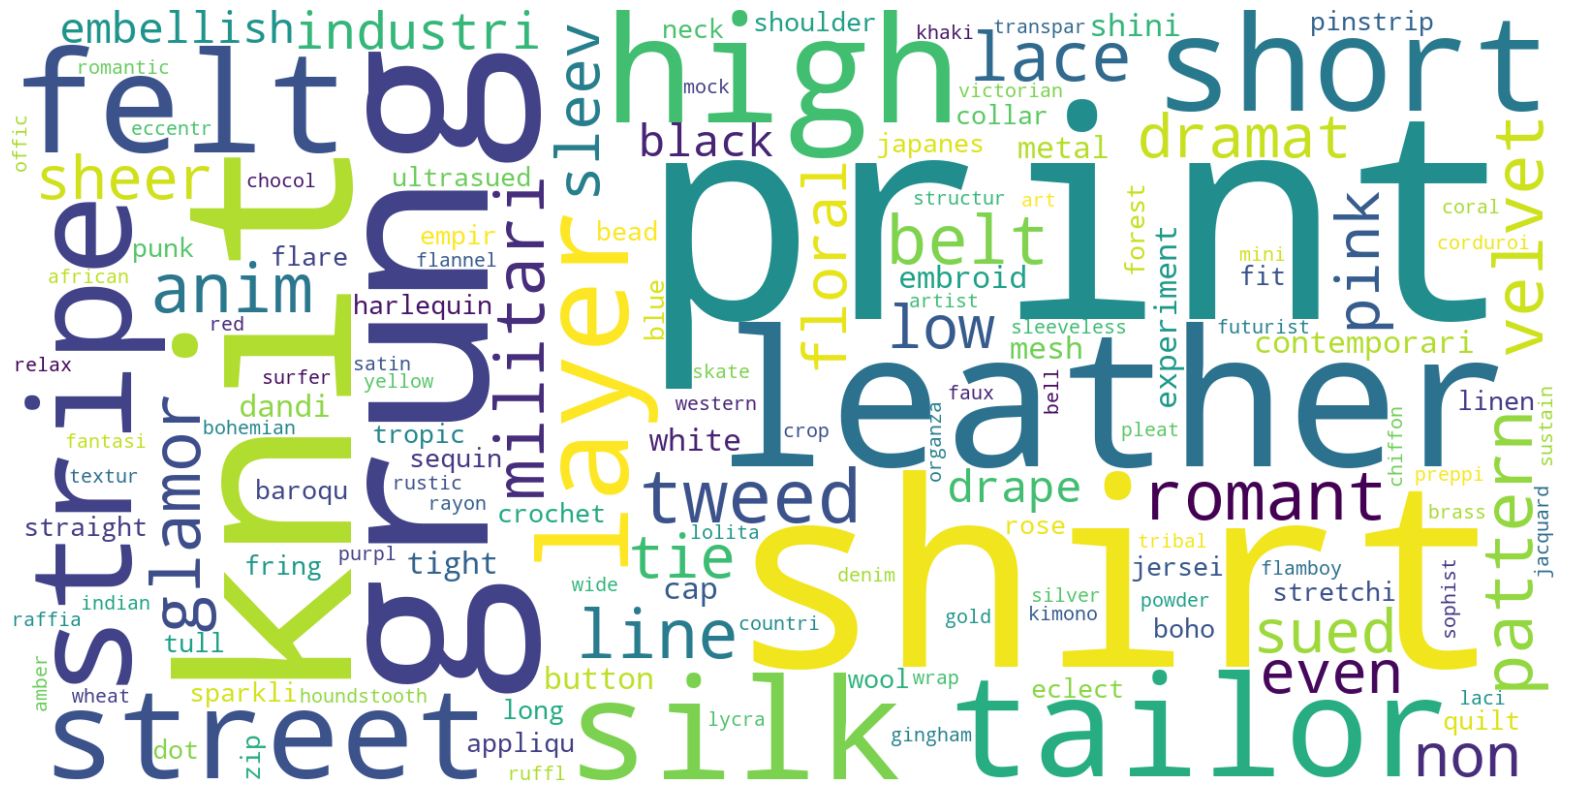

In [66]:
make_wc(1990, 1994)

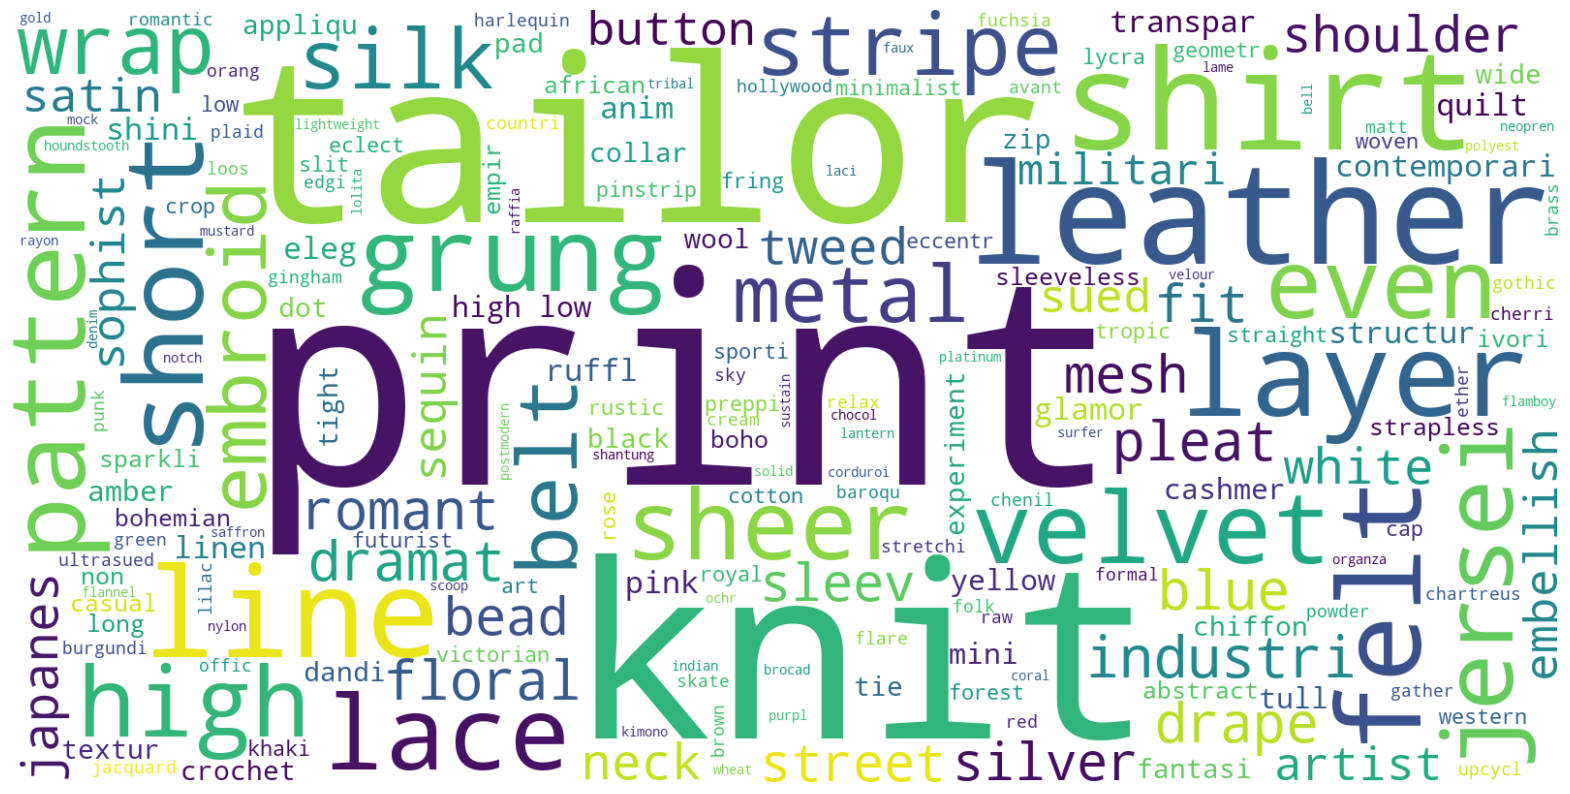

In [67]:
make_wc(1995, 1999)

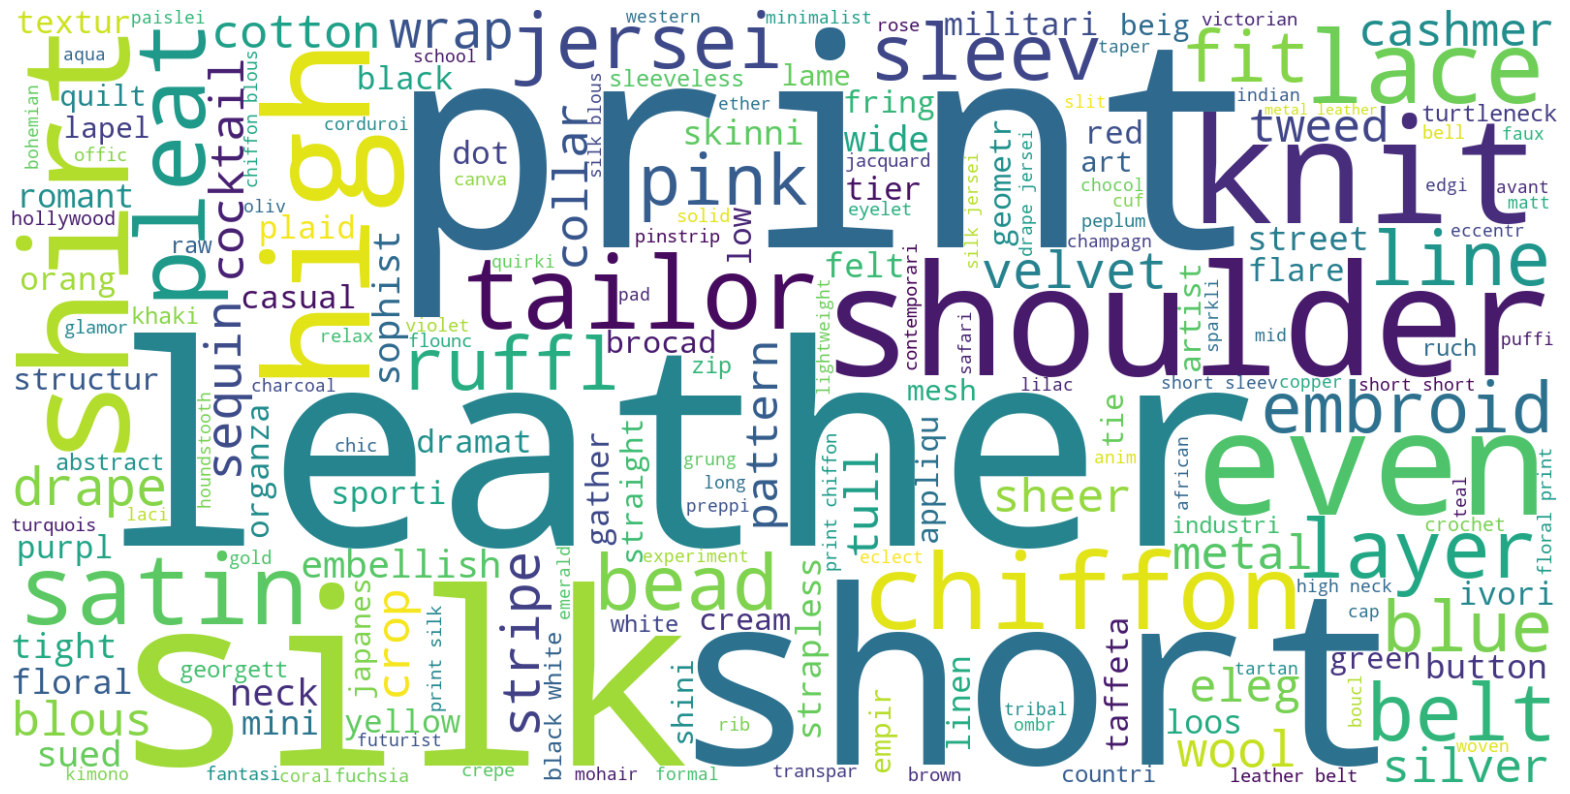

In [69]:
make_wc(2000, 2009)

### K-means clustering

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer

X = collections['preprocessed_sentences']
y = collections['designer']

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 120)

In [22]:
tfidf = TfidfVectorizer(ngram_range=(1,2)).fit(X)
X_transformed = tfidf.transform(X)

In [16]:
# Clustering the training sentences with K-means technique

from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, init='k-means++', n_init ='auto')
km.fit(X_transformed)

KMeans(n_clusters=50, n_init='auto')

In [17]:
collections['cluster'] = km.labels_
collections.groupby('cluster').describe()

year                                                           \
         count         mean       std     min      25%     50%      75%   
cluster                                                                   
0        256.0  2015.449219  5.959780  1992.0  2012.00  2016.0  2020.00   
1        195.0  2016.046154  6.564739  1991.0  2011.00  2019.0  2021.00   
2        220.0  2012.090909  5.688321  1994.0  2008.00  2012.0  2016.25   
3        124.0  2013.000000  0.000000  2013.0  2013.00  2013.0  2013.00   
4        174.0  2012.362069  5.302519  1992.0  2010.00  2013.0  2016.00   
5        455.0  2012.534066  5.114379  1998.0  2010.00  2013.0  2015.00   
6        324.0  2014.765432  5.879642  1993.0  2011.00  2016.0  2019.00   
7        295.0  2012.223729  6.127676  1999.0  2008.00  2013.0  2017.00   
8        245.0  2011.183673  5.948114  1996.0  2007.00  2011.0  2015.00   
9        203.0  2015.078818  6.732049  1991.0  2011.00  2017.0  2020.00   
10       331.0  2015.888218  5.340203  1991.0  2013.00  2017.0  2020.00   
11       249.0  2013.566265  5.337465  1998.0  2010.00  2014.0  2017.00   
12       406.0  2013.588670  5.947156  1998.0  2010.00  2015.0  2018.00   
13       388.0  2014.206186  5.673618  1992.0  2011.00  2015.0  2018.00   
14        92.0  2014.869565  5.090861  1996.0  2011.00  2015.0  2019.00   
15       434.0  2011.576037  6.164038  1990.0  2007.00  2012.0  2016.00   
16       259.0  2010.258687  6.472862  1997.0  2005.00  2010.0  2015.00   
17       352.0  2015.204545  5.880886  1995.0  2012.00  2016.0  2019.00   
18        94.0  2014.329787  7.886818  1993.0  2012.25  2017.0  2020.00   
19       350.0  2013.157143  4.980868  1998.0  2011.00  2013.0  2016.00   
20       625.0  2013.684800  6.029961  1994.0  2010.00  2016.0  2018.00   
21       279.0  2013.971326  5.659960  1995.0  2010.00  2015.0  2018.00   
22       376.0  2013.053191  6.239431  1992.0  2009.00  2014.0  2018.00   
23       188.0  2009.781915  5.231567  2000.0  2006.75  2009.5  2013.00   
24       413.0  2012.905569  6.308670  1998.0  2008.00  2014.0  2018.00   
25       339.0  2018.587021  4.052241  1994.0  2017.00  2020.0  2021.00   
26       210.0  2013.890476  5.604373  1991.0  2011.00  2015.0  2017.00   
27       272.0  2015.687500  6.194998  1993.0  2014.00  2017.0  2020.00   
28       138.0  2013.550725  4.945059  2000.0  2011.00  2014.0  2016.75   
29       235.0  2011.489362  6.505331  1991.0  2007.00  2012.0  2016.00   
30       272.0  2016.952206  5.400690  1991.0  2014.00  2019.0  2021.00   
31       278.0  2013.064748  5.589713  1993.0  2010.00  2013.0  2017.00   
32       192.0  2013.005208  4.977959  2000.0  2010.00  2014.0  2016.00   
33        91.0  2014.296703  7.040351  1992.0  2011.00  2016.0  2019.00   
34       632.0  2015.511076  5.859951  1993.0  2012.00  2017.0  2020.00   
35       249.0  2012.437751  5.480642  1995.0  2009.00  2013.0  2016.00   
36        63.0  2010.761905  6.189779  2000.0  2006.00  2011.0  2015.00   
37       192.0  2013.619792  6.816689  1991.0  2009.00  2015.0  2018.00   
38       221.0  2014.484163  6.534244  1991.0  2010.00  2017.0  2019.00   
39        40.0  2018.825000  2.205907  2015.0  2017.75  2018.0  2020.25   
40       181.0  2013.447514  5.930501  1997.0  2010.00  2014.0  2018.00   
41       145.0  2009.820690  6.064089  1992.0  2006.00  2009.0  2014.00   
42       329.0  2014.595745  6.148377  1997.0  2011.00  2015.0  2019.00   
43       608.0  2015.286184  6.388855  1995.0  2011.00  2017.0  2021.00   
44       820.0  2015.493902  6.369663  1990.0  2012.00  2016.0  2021.00   
45       576.0  2013.987847  6.113266  1990.0  2010.00  2015.0  2019.00   
46       138.0  2013.413043  5.704049  1994.0  2011.00  2014.0  2017.75   
47        75.0  2014.253333  5.322297  2000.0  2012.00  2015.0  2018.50   
48       179.0  2014.027933  5.643362  1999.0  2011.00  2015.0  2019.00   
49       459.0  2016.790850  5.312078  1996.0  2014.00  2018.0  2021.00   

                seasonyear        

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

# Number of clusters
num_clusters = 30

# Initialize a list to store the labels from each run
all_labels = []

# Run K-means algorithm multiple times
num_runs = 10  
for _ in range(num_runs):
    km = KMeans(n_clusters=num_clusters, init='k-means++')
    km.fit(X_transformed)
    all_labels.append(km.labels_)

# Create a frequency table from the labels
frequency_table = pd.DataFrame(all_labels).apply(pd.Series.value_counts)

# Fill NaN values with 0
frequency_table = frequency_table.fillna(0)

# Convert frequency table into an adjacency matrix
adjacency_matrix = frequency_table.dot(frequency_table.T)

# Output the adjacency matrix
print(adjacency_matrix)
